# Hystersis Loop Dataset - AFM

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pycroscopy/DTMicroscope/blob/main/notebooks/Static%20Problems/LoopFittingProblem.ipynb)

 This dataset is a 50x50 hysteresis loop dataset on a PbTiO3 thin film, acquired by piezoresponse force spectroscopy. You can use this to test different fitting algorithms. The X,Y scale on the images is 2um

by R. Vasudevan (CNMS/ORNL)


In [6]:

!pip install SciFiReaders

--2025-12-17 15:51:48--  https://github.com/pycroscopy/DTMicroscope/blob/main/data/AFM/BEPS_PTO_50x50.h5
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘BEPS_PTO_50x50.h5.1’

BEPS_PTO_50x50.h5.1     [ <=>                ] 184.01K  1.18MB/s    in 0.2s    

2025-12-17 15:51:49 (1.18 MB/s) - ‘BEPS_PTO_50x50.h5.1’ saved [188428]



In [10]:
!wget https://raw.githubusercontent.com/pycroscopy/DTMicroscope/main/data/AFM/BEPS_PTO_50x50.h5

--2025-12-17 15:54:36--  https://raw.githubusercontent.com/pycroscopy/DTMicroscope/main/data/AFM/BEPS_PTO_50x50.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1297264 (1.2M) [application/octet-stream]
Saving to: ‘BEPS_PTO_50x50.h5.1’

BEPS_PTO_50x50.h5.1 100%[===================>]   1.24M  6.93MB/s    in 0.2s    

2025-12-17 15:54:37 (6.93 MB/s) - ‘BEPS_PTO_50x50.h5.1’ saved [1297264/1297264]



In [11]:
import matplotlib.pyplot as plt
import numpy as np
import SciFiReaders as sr
colab = True #Set to True if in Google Colab, else set to False
if colab:
    %matplotlib widget
    from google.colab import output
    output.enable_custom_widget_manager()

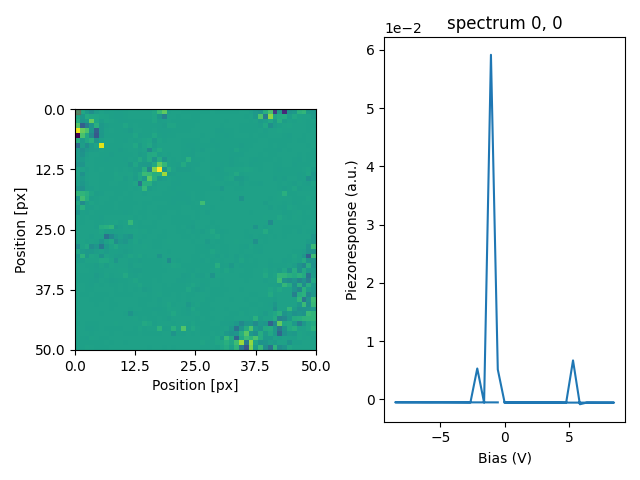

In [15]:
#import the data
reader = sr.NSIDReader('/content/BEPS_PTO_50x50.h5.1')
datasets = reader.read()

#for interactive plotting
fig = datasets['Channel_000'].plot()

#for conversion to numpy
hysteresis_loops = np.array(datasets['Channel_000'])
dc_vec = datasets['Channel_000']._axes[2].values

# Plot some random loops

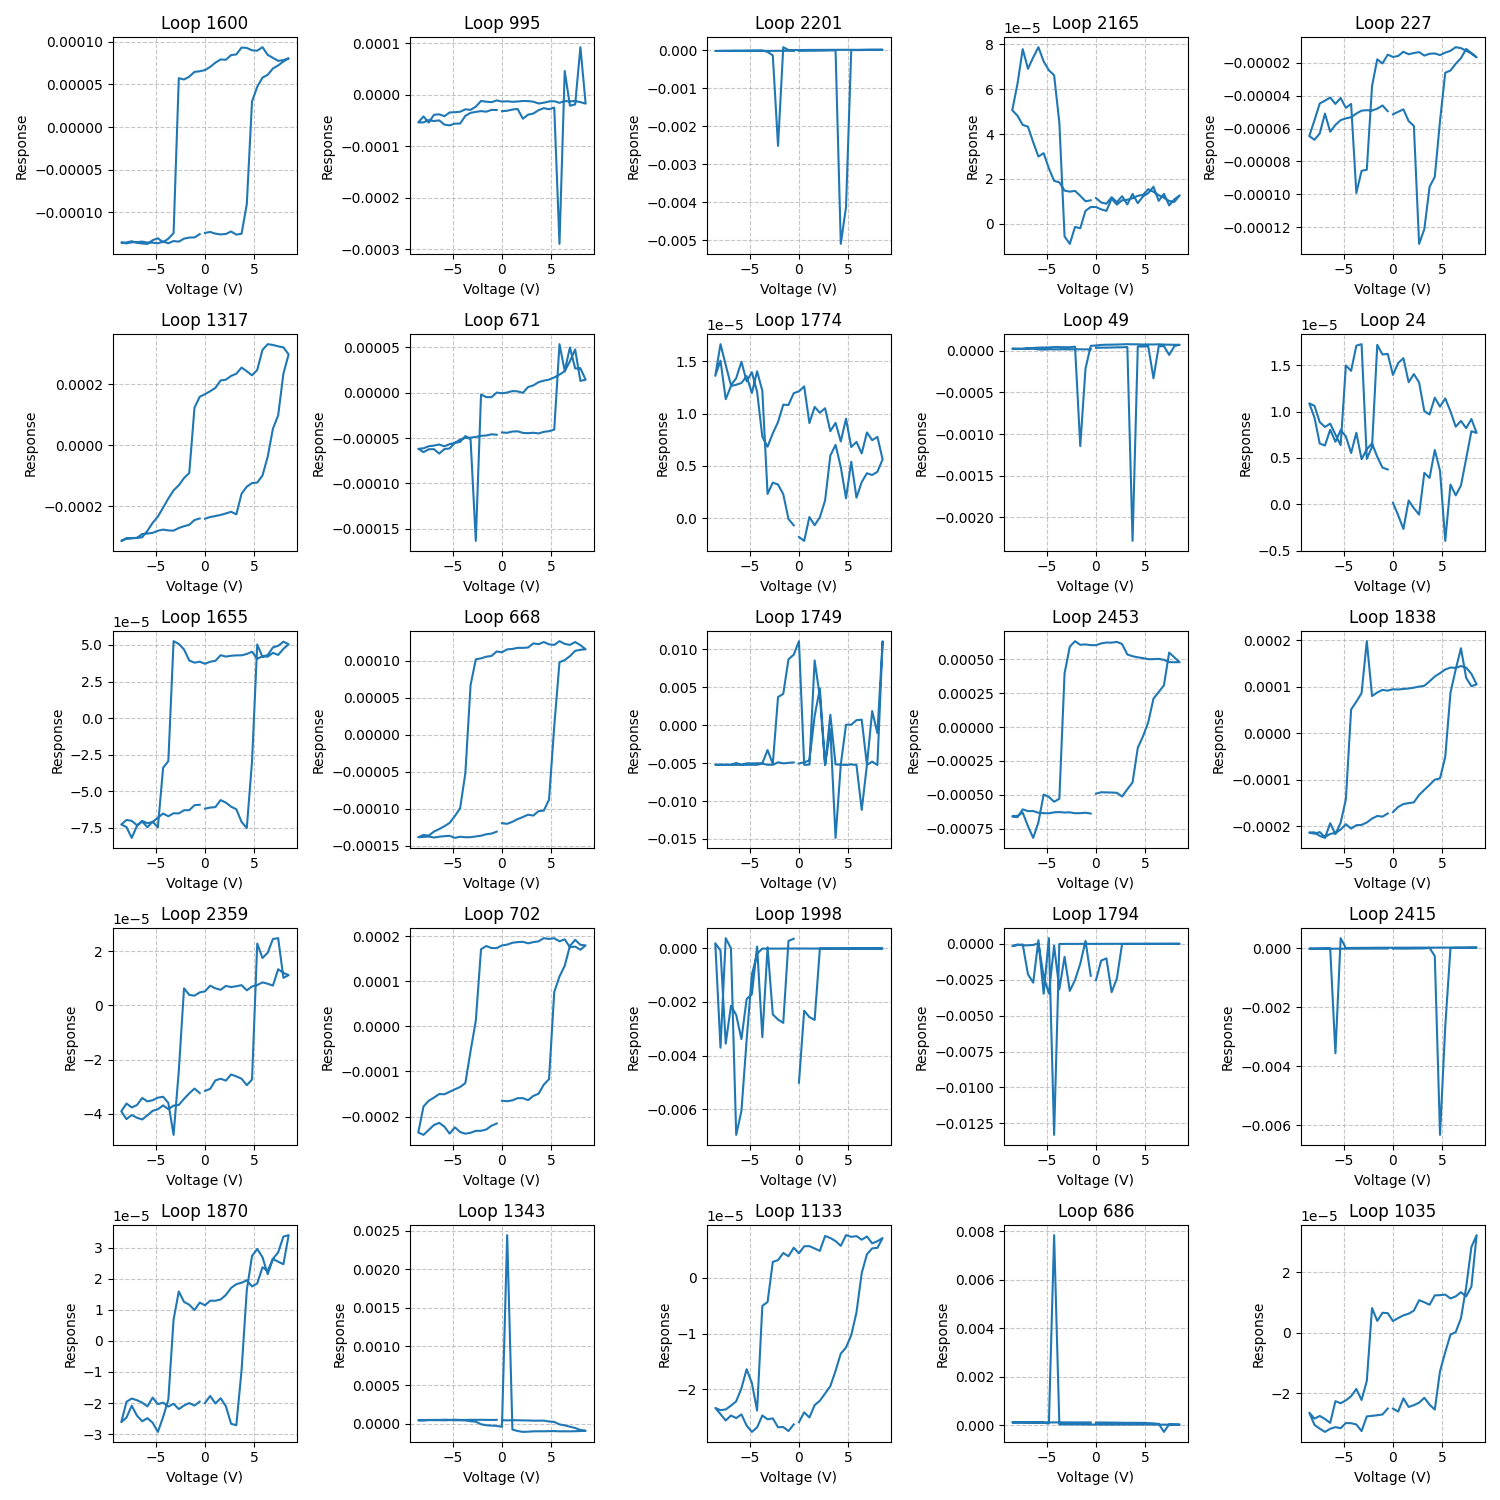

In [16]:

if hysteresis_loops.ndim == 3:
    loops_flat = hysteresis_loops.reshape(-1, hysteresis_loops.shape[-1])
else:
    loops_flat = hysteresis_loops

num_loops_to_plot = 25
# Randomly select 25 indices for the hysteresis loops to plot
random_indices = np.random.choice(loops_flat.shape[0], num_loops_to_plot, replace=False)

# Create a 5x5 grid of subplots
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten() # Flatten the 5x5 array of axes for easier iteration

# Plot each random hysteresis loop in a separate subplot
for i, ax in enumerate(axes):
    loop_index = random_indices[i]
    loop_data = loops_flat[loop_index]

    ax.plot(dc_vec, loop_data)
    ax.set_title(f'Loop {loop_index}')
    ax.set_xlabel('Voltage (V)')
    ax.set_ylabel('Response')
    ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

## The loop fit function is defined in the cell below.
## This is the fit function for the loop - be careful with the DC vector!

In [23]:
from scipy.special import erf
def loop_fit_function(vdc, *coef_vec):
    """
    9 parameter fit function

    Parameters
    -----------
    vdc : 1D numpy array or list
        DC voltages
    coef_vec : 1D numpy array or list
        9 parameter coefficient vector

    Returns
    ---------
    loop_eval : 1D numpy array
        Loop values
    """

    a = coef_vec[:5]
    b = coef_vec[5:]
    d = 1000

    v1 = np.asarray(vdc[:int(len(vdc) / 2)])
    v2 = np.asarray(vdc[int(len(vdc) / 2):])

    g1 = (b[1] - b[0]) / 2 * (erf((v1 - a[2]) * d) + 1) + b[0]
    g2 = (b[3] - b[2]) / 2 * (erf((v2 - a[3]) * d) + 1) + b[2]

    y1 = (g1 * erf((v1 - a[2]) / g1) + b[0]) / (b[0] + b[1])
    y2 = (g2 * erf((v2 - a[3]) / g2) + b[2]) / (b[2] + b[3])

    f1 = a[0] + a[1] * y1 + a[4] * v1
    f2 = a[0] + a[1] * y2 + a[4] * v2

    loop_eval = np.hstack((f1, f2))
    return loop_eval

#Using this loop fit function, fit the projected loop (the third panel in the previous figure).
#You will need to be careful about the way the x vector is passed it needs to be 'rolled'
#I.e., Vdc needs to be increasing on one branch and decreasing on another, and split in the middle.

## Example using standard curve fit

### Importance of rolling!
Select a hysteresis loop from `loops_flat`  and plot it, make sure you roll it though!


Text(0, 0.5, 'Piezoresponse (a.u.)')

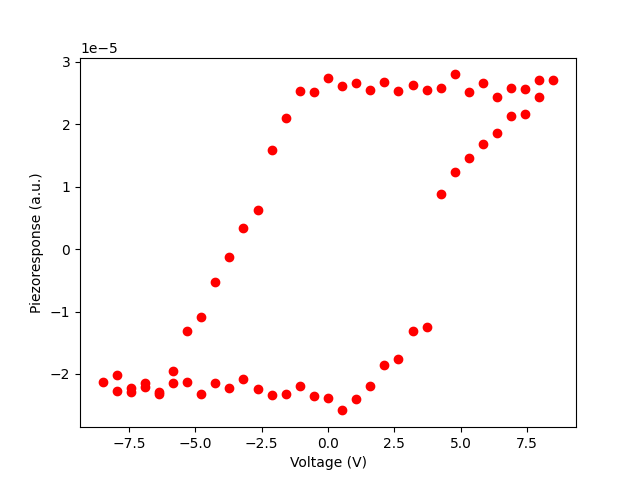

In [20]:
selected_loop_index = 1921
selected_loop_data = loops_flat[selected_loop_index]

plt.figure()
plt.plot(np.roll(dc_vec,-16),np.roll(selected_loop_data,-16), 'ro' )
plt.xlabel('Voltage (V)')
plt.ylabel('Piezoresponse (a.u.)')

In [24]:
from scipy.optimize import curve_fit

selected_loop_index = 1921
selected_loop_data = loops_flat[selected_loop_index]

dc_vec_rolled = np.roll(dc_vec,-16) #rolling is essential
selected_loop_data_rolled = np.roll(selected_loop_data,-16)*1.0E5

# Initial guess for the 9 parameters of the loop_fit_function
# These values are often refined through trial and error or domain knowledge
initial_guess = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
lb = ([-100, -100, -100, -100, -100, -100, -100, -100, -100])
ub = ([100, 100, 100, 100, 100, 100, 100, 100, 100])
#Use curve fit to find the fitted loop parameters
popt, pcov = curve_fit(loop_fit_function, dc_vec_rolled, selected_loop_data_rolled, p0=initial_guess, bounds = (lb,ub))


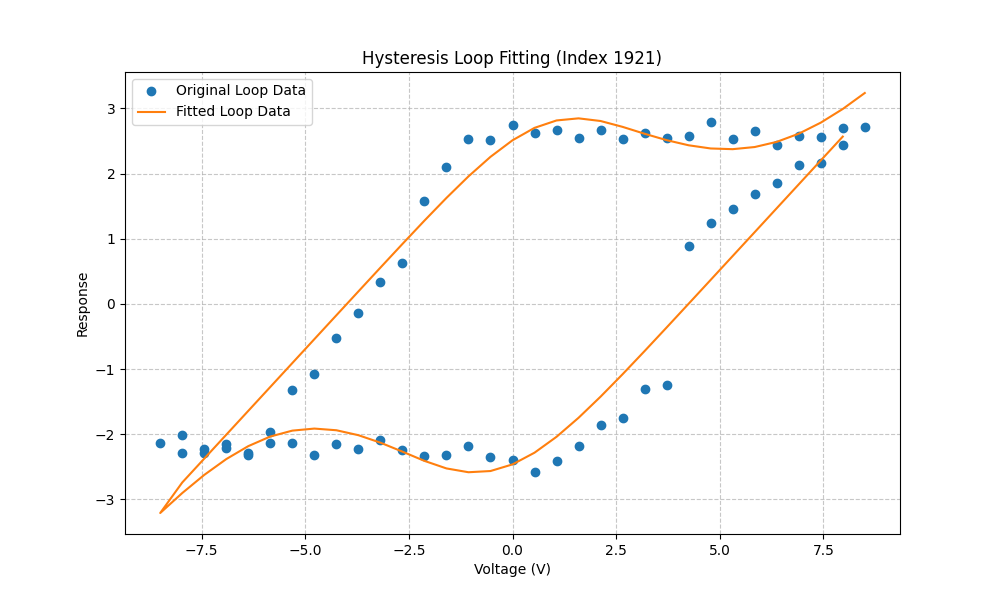

Original and fitted hysteresis loops plotted.


In [25]:
##Plot the fitted loop
fitted_loop_data = loop_fit_function(dc_vec_rolled, *popt)

plt.figure(figsize=(10, 6))
plt.plot(dc_vec_rolled, selected_loop_data_rolled, 'o', label='Original Loop Data')
plt.plot(dc_vec_rolled, fitted_loop_data, '-', label='Fitted Loop Data')
plt.title(f'Hysteresis Loop Fitting (Index {selected_loop_index})')
plt.xlabel('Voltage (V)')
plt.ylabel('Response')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print("Original and fitted hysteresis loops plotted.")